In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import truncnorm
sns.set_theme()
from SimFinal import *

In [2]:
import math
import itertools
from typing import List, Dict, Tuple, Optional


def get_fastest_study_lookahead(
    patient_remaining_studies: List[Study], 
    lines: Dict[str, int],
    lookahead_depth: int = 1
) -> Study | None:
    """
    Calculates the study with the shortest estimated total completion time,
    considering the optimal sequence of the next n studies.
    
    Args:
        patient_remaining_studies: List of Study objects the patient still needs
        lines: Current queue lengths for each study type
        lookahead_depth: Number of studies ahead to consider in optimization
        
    Returns:
        The Study object that should be done first for optimal total time,
        or None if no valid studies available
    """
    if not patient_remaining_studies:
        return None
    
    # Filter out studies with no available locales
    valid_studies = [
        study for study in patient_remaining_studies 
        if study.locales > 0
    ]
    
    if not valid_studies:
        return None
    
    # If only one study or lookahead is 1, use original logic
    if len(valid_studies) == 1 or lookahead_depth == 1:
        return _get_single_fastest_study(valid_studies, lines)
    
    # Limit lookahead to available studies
    actual_lookahead = min(lookahead_depth, len(valid_studies))
    
    best_first_study = None
    best_total_time = float('inf')
    
    # Try each study as the first choice
    for first_study in valid_studies:
        # Calculate total time if we start with this study
        total_time = _calculate_sequence_time(
            valid_studies, lines, first_study, actual_lookahead
        )
        
        if total_time < best_total_time:
            best_total_time = total_time
            best_first_study = first_study
    
    return best_first_study


def _get_single_fastest_study(studies: List[Study], lines: Dict[str, int]) -> Study:
    """Original single-study logic for comparison and fallback"""
    times = {}
    for study in studies:
        line_length = lines.get(study.name, 0)
        cycle_number = math.ceil((line_length + 1) / study.locales)
        estimated_wait = (cycle_number - 1) * study.time
        times[estimated_wait] = study
    
    min_wait = min(times.keys())
    return times[min_wait]


def _calculate_sequence_time(
    all_studies: List[Study], 
    initial_lines: Dict[str, int], 
    first_study: Study, 
    lookahead_depth: int
) -> float:
    """
    Calculate the total time to complete a sequence starting with first_study.
    Uses dynamic programming approach to find optimal ordering of remaining studies.
    """
    # Simulate the queue state after choosing first_study
    simulated_lines = initial_lines.copy()
    
    # Calculate wait time for first study
    first_wait_time = _calculate_study_wait_time(first_study, simulated_lines)
    total_time = first_wait_time + first_study.time
    
    # Update simulated lines (this patient joins the queue)
    simulated_lines[first_study.name] = simulated_lines.get(first_study.name, 0) + 1
    
    # Get remaining studies for optimization
    remaining_studies = [s for s in all_studies if s != first_study]
    
    if not remaining_studies or lookahead_depth <= 1:
        return total_time
    
    # Find optimal sequence for remaining studies
    remaining_time = _find_optimal_sequence(
        remaining_studies, 
        simulated_lines, 
        lookahead_depth - 1,
        current_time=total_time
    )
    
    return total_time + remaining_time


def _find_optimal_sequence(
    studies: List[Study], 
    lines: Dict[str, int], 
    remaining_depth: int,
    current_time: float = 0
) -> float:
    """
    Find the optimal ordering of remaining studies using dynamic programming.
    Uses memoization to avoid recalculating the same subproblems.
    """
    if not studies or remaining_depth <= 0:
        return 0
    
    # For small numbers of studies, try all permutations
    if len(studies) <= 8:  # Factorial grows quickly, limit to reasonable size
        return _try_all_permutations(studies, lines, remaining_depth, current_time)
    
    # For larger sets, use greedy approach with limited lookahead
    return _greedy_with_lookahead(studies, lines, remaining_depth, current_time)


def _try_all_permutations(
    studies: List[Study], 
    lines: Dict[str, int], 
    remaining_depth: int,
    current_time: float
) -> float:
    """Try all possible orderings for small study sets"""
    if len(studies) == 1:
        study = studies[0]
        wait_time = _calculate_study_wait_time(study, lines)
        return wait_time + study.time
    
    best_time = float('inf')
    
    # Try each study as the next choice
    for next_study in studies:
        # Calculate time for this choice
        wait_time = _calculate_study_wait_time(next_study, lines)
        study_completion_time = wait_time + next_study.time
        
        # Simulate queue state after this study
        new_lines = lines.copy()
        new_lines[next_study.name] = new_lines.get(next_study.name, 0) + 1
        
        # Calculate optimal time for remaining studies
        remaining_studies = [s for s in studies if s != next_study]
        remaining_time = _find_optimal_sequence(
            remaining_studies, 
            new_lines, 
            remaining_depth - 1,
            current_time + study_completion_time
        )
        
        total_time = study_completion_time + remaining_time
        best_time = min(best_time, total_time)
    
    return best_time


def _greedy_with_lookahead(
    studies: List[Study], 
    lines: Dict[str, int], 
    remaining_depth: int,
    current_time: float
) -> float:
    """Greedy approach with limited lookahead for larger study sets"""
    total_time = 0
    current_lines = lines.copy()
    remaining_studies = studies[:]
    depth_used = 0
    
    while remaining_studies and depth_used < remaining_depth:
        # Find best next study using single-step lookahead
        best_study = None
        best_immediate_time = float('inf')
        
        for study in remaining_studies:
            wait_time = _calculate_study_wait_time(study, current_lines)
            immediate_time = wait_time + study.time
            
            if immediate_time < best_immediate_time:
                best_immediate_time = immediate_time
                best_study = study
        
        if best_study is None:
            break
            
        # Add this study's time and update state
        total_time += best_immediate_time
        current_lines[best_study.name] = current_lines.get(best_study.name, 0) + 1
        remaining_studies.remove(best_study)
        depth_used += 1
    
    return total_time


def _calculate_study_wait_time(study: Study, lines: Dict[str, int]) -> float:
    """Calculate wait time for a specific study given current queue lengths"""
    line_length = lines.get(study.name, 0)
    cycle_number = math.ceil((line_length + 1) / study.locales)
    return (cycle_number - 1) * study.time


# Backward compatibility - replace the original function
def get_fastest_study(
    patient_remaining_studies: List[Study], 
    lines: Dict[str, int],
    lookahead_depth: int = 1
) -> Study | None:
    """
    Enhanced version of get_fastest_study with configurable lookahead.
    Maintains backward compatibility by defaulting to lookahead_depth=1.
    """
    return get_fastest_study_lookahead(patient_remaining_studies, lines, lookahead_depth)

In [3]:
# Generate patients
def generate_patients(n, studies, min_studies, max_studies):
    patients = []
    mean = (min_studies + max_studies) / 2
    a = (min_studies - mean)
    b = (max_studies - mean)

    for i in range(n):
        truncated_floats = truncnorm.rvs(a=a, b=b, loc=mean)
        integers = np.round(truncated_floats).astype(int)
        integers = np.clip(integers, min_studies, max_studies)
        data = dict()
        data["id"] = i
        data["studies"] = random.sample(
            list(studies.keys()), integers
        )
        patients.append(data)
    return patients

In [4]:
studies_definitions = {
    "densitometria": Study("densitometria", 2, 7),
    "electrocardiograma": Study("electrocardiograma", 2, 7),
    "laboratorio": Study("laboratorio", 13, 3),
    "mastografia": Study("mastografia", 3, 8),
    "nutricion": Study("nutricion", 2, 13),
    "optometria": Study("optometria", 6, 10),
    "papanicolaou": Study("papanicolaou", 1, 8),
    "rayosx": Study("rayosx", 2, 5),
    "rem": Study("rem", 1, 32),
    "tomografia": Study("tomografia", 1, 14),
    "ultrasonido": Study("ultrasonido", 7, 16),
}

In [5]:
admission_schedule_example = {
    (0, 300): 0.0,
    (300, 360): 1.7, # 6AM
    (360, 420): 2.1,
    (420, 480): 2.2,
    (480, 540): 2.1,
    (540, 600): 1.9,
    (600, 660): 1.1,
    (660, 720): 1.1,
    (720, 780): 0.7,
    (780, 840): 0.5,
    (840, 900): 0.5,
    (900, 960): 0.8,
    (960, 1020): 0.5,
    (1020, 1080): 0.3,
    (1080, 1440): 0.0,
}

In [6]:
simulation_duration = 1440

In [7]:
# Define your admission schedule (choose one or create your own)
operational_hours = 8
total_operational_minutes = operational_hours * 60
avg_admission_rate = 950 / total_operational_minutes if total_operational_minutes > 0 else 0

# Example: Constant average rate over operational hours, then zero
my_admission_schedule = {
    (0, total_operational_minutes): avg_admission_rate,
    (total_operational_minutes, simulation_duration): 0.0 
}

In [15]:
min_studies = 1
max_studies = 7

In [16]:
%%capture
# lookaheads = [] # Original: stored num_completed
lookaheads_num_completed = [] # To store number of completed patients
lookaheads_avg_wait_completed = [] # New: to store average wait times


for l in range(max_studies): # Lookahead depth from 0 to 6
    num_completed_results_for_l = []
    avg_wait_results_for_l = []
    for _ in range(100): # 100 simulation runs per lookahead value
        # Generate Patients
        random_patients = generate_patients(950, studies_definitions, min_studies, max_studies)
        patients_master_list = []
        for p_data in random_patients:
            patient_studies = [
                deepcopy(studies_definitions[s_name]) for s_name in p_data["studies"]
            ]
            # Patient class now initializes total_wait_time to 0 and time_entered_current_queue to 0.0
            patients_master_list.append(Patient(studies=patient_studies, id_num=p_data["id"]))
    
        # Parameters
        simulation_duration = 1440
        patients_to_admit_each_step = 1
        
        # Lookahead Run
        patient_queue_for_sim = [deepcopy(p) for p in patients_master_list]
        final_state = simulate_workflow(
            get_fastest_study, # This is your enhanced get_fastest_study_lookahead
            initial_patient_list=patient_queue_for_sim,
            study_defs=studies_definitions,
            time_period=simulation_duration,
            admission_schedule=my_admission_schedule, # Pass the schedule
            show_steps=False, # Set to False for multiple runs
            lookahead=l # Pass the actual lookahead depth (l will be 0 for the first iteration, which means lookahead_depth=1 in your func)
        )
        num_completed_results_for_l.append(len(final_state['completed_patients']))
        avg_wait_results_for_l.append(final_state['average_wait_time_completed'])
        
    lookaheads_num_completed.append(num_completed_results_for_l)
    lookaheads_avg_wait_completed.append(avg_wait_results_for_l)

In [17]:
%%capture
# random_results = [] # Original
random_num_completed_results = []
random_avg_wait_completed_results = []

for _ in range(100):
    # Generate Patients (same as above, ensure Patient init handles new attributes)
    random_patients = generate_patients(950, studies_definitions, min_studies, max_studies)
    patients_master_list = []
    for p_data in random_patients:
        patient_studies = [
            deepcopy(studies_definitions[s_name]) for s_name in p_data["studies"]
        ]
        patients_master_list.append(Patient(studies=patient_studies, id_num=p_data["id"]))

    # Parameters
    simulation_duration = 1440
    patients_to_admit_each_step = 1
    
    # Random Run
    patient_queue_for_sim_random = [deepcopy(p) for p in patients_master_list]
    # Assuming simulate_workflow_random is modified similarly to simulate_workflow
    # If simulate_workflow_random uses a different patient assignment logic
    # but the core time-stepping and state management (active, waiting) is similar,
    # the wait time tracking can be added there too.
    # For now, I'll assume it needs similar internal changes for wait time.
    # If it's very different, you'll need to adapt the wait tracking logic within it.
    
    # Create a dummy get_random_study function for simulate_workflow if you adapt it,
    # or modify simulate_workflow_random directly
    def get_random_study_for_patient(patient_remaining_studies: List[Study], lines: Dict[str, int], lookahead_depth: int = 1):
        if not patient_remaining_studies:
            return None
        performable_studies = [s for s in patient_remaining_studies if s.locales > 0]
        if not performable_studies:
            return None
        return random.choice(performable_studies)

    final_state_random = simulate_workflow( # Using the modified simulate_workflow with random choice
        get_random_study_for_patient, # Pass the random choice function
        initial_patient_list=patient_queue_for_sim_random,
        study_defs=studies_definitions,
        time_period=simulation_duration,
        show_steps=False,
        lookahead=1 # lookahead parameter is not used by get_random_study_for_patient
    )
    random_num_completed_results.append(len(final_state_random['completed_patients']))
    random_avg_wait_completed_results.append(final_state_random['average_wait_time_completed'])

In [18]:
lookaheads_avg_wait_completed.append(random_avg_wait_completed_results)

In [19]:
import pandas as pd

<Figure size 1000x700 with 0 Axes>

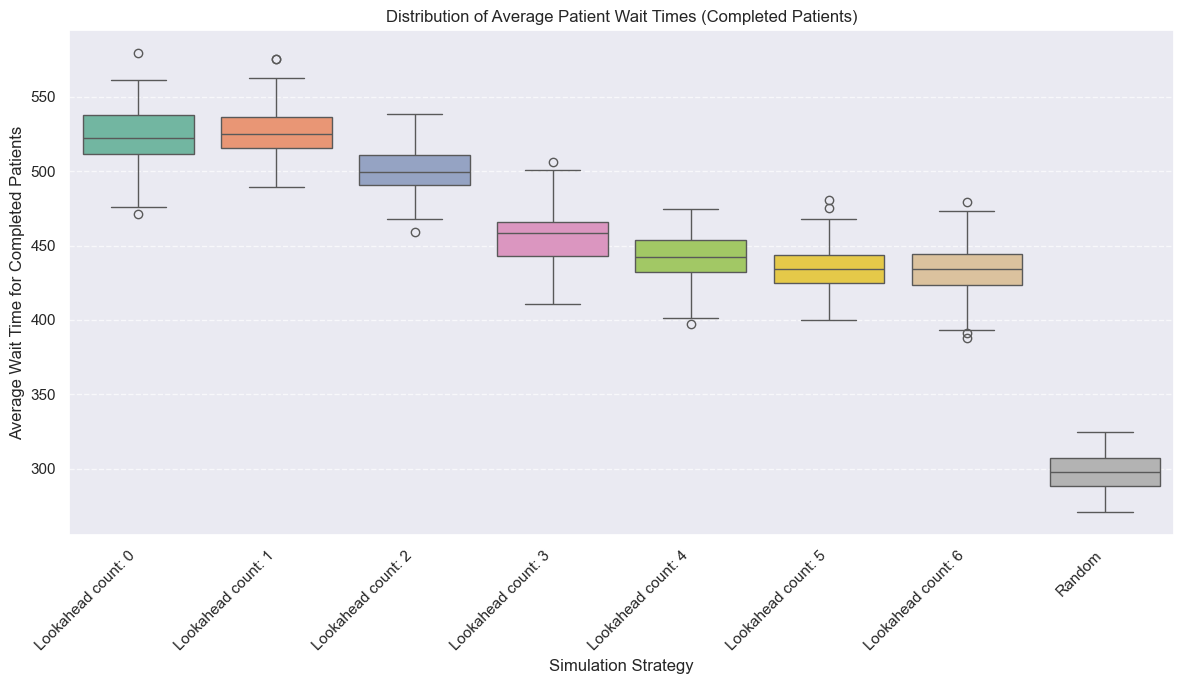

In [22]:
labels_wait = [f'Lookahead count: {i}' for i in range(len(lookaheads_avg_wait_completed) -1 )] + ["Random"]


plt.figure(figsize=(10, 7))
# Ensure lookaheads_avg_wait_completed is a list of lists suitable for plt.hist or plt.boxplot
# If using hist like before:
# plt.hist(lookaheads_avg_wait_completed, label=labels_wait, bins=20) # Adjust bins as needed

# A boxplot might be more suitable for comparing distributions of averages:
df_avg_wait_plot = []
for i, data_series in enumerate(lookaheads_avg_wait_completed):
    for value in data_series:
        df_avg_wait_plot.append({'Category': labels_wait[i], 'Average Wait Time (Completed)': value})
df_avg_wait_long = pd.DataFrame(df_avg_wait_plot)

plt.figure(figsize=(12, 7))
sns.boxplot(x='Category', y='Average Wait Time (Completed)', data=df_avg_wait_long, hue='Category', palette="Set2", legend=False)
plt.xlabel("Simulation Strategy")
plt.ylabel("Average Wait Time for Completed Patients")
plt.title("Distribution of Average Patient Wait Times (Completed Patients)")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

<Figure size 1000x700 with 0 Axes>

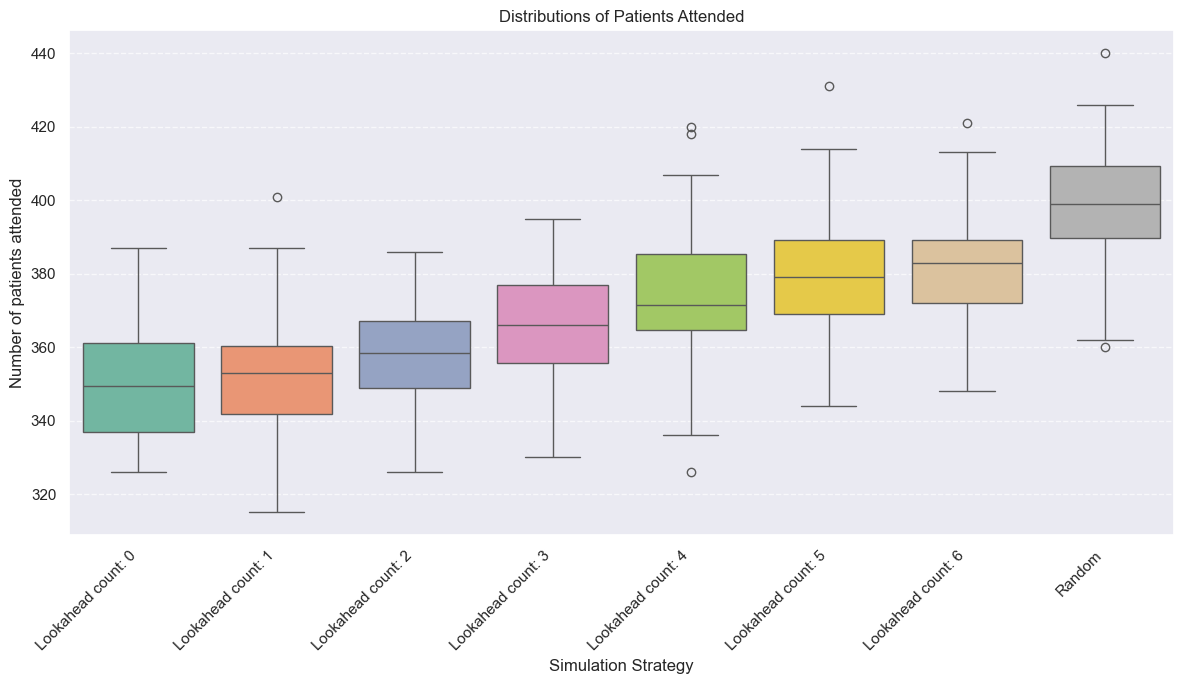

In [21]:
lookaheads_num_plot_data = lookaheads_num_completed + [random_num_completed_results]
labels_num_plot = [f'Lookahead count: {i}' for i in range(len(lookaheads_num_completed))] + ["Random"]


plt.figure(figsize=(10, 7))
# plt.hist(lookaheads_num_plot_data, label=labels_num_plot, bins=common_bins) # Assuming common_bins is for patient counts
# Or using boxplot for consistency:
df_num_completed_plot = []
for i, data_series in enumerate(lookaheads_num_plot_data):
    for value in data_series:
        df_num_completed_plot.append({'Category': labels_num_plot[i], 'Number of patients attended': value})
df_num_completed_long = pd.DataFrame(df_num_completed_plot)

plt.figure(figsize=(12, 7))
sns.boxplot(x='Category', y='Number of patients attended', data=df_num_completed_long, hue='Category', palette="Set2", legend=False)
plt.xlabel("Simulation Strategy")
plt.ylabel("Number of patients attended")
plt.title("Distributions of Patients Attended")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()